# Analyzing the parameters of predictive models, re-running models with parameter subsets identified by LassoCV

## 1. Load data, model parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# load parameters for lasso on clinical-full, proteomics, metabolomics, and all

In [3]:
clinical_classification_weights = pd.read_csv('results_2023_10_18/clinical_classification_lasso_weights.csv')

In [4]:
prot_regression_weights = pd.read_csv('results_2023_10_18/prots_lassocv_weights.csv')

met_regression_weights = pd.read_csv('results_2023_10_18/mets_imputed_lassocv_weights.csv')

all_regression_weights = pd.read_csv('results_2023_10_18/all_lassocv_weights.csv')

prot_classification_weights = pd.read_csv('results_2023_10_18/prots_classification_lasso_weights.csv')

met_classification_weights = pd.read_csv('results_2023_10_18/mets_imputed_classification_lasso_weights.csv')

all_classification_weights = pd.read_csv('results_2023_10_18/all_classification_lasso_weights.csv')

In [5]:
prot_names = pd.read_csv('../arivale_data/arivale_prots.tsv', sep='\t')

In [6]:
prot_names.index = prot_names['index']

In [7]:
met_names = pd.read_csv('../arivale_data/arivale_mets.tsv', sep='\t')

In [8]:
met_names.index = met_names['CHEMICAL_ID'].astype(str)

In [9]:
met_names

,index,0,CHEMICAL_ID,SUB_PATHWAY,SUPER_PATHWAY,BIOCHEMICAL_NAME,CAS,KEGG,HMDB,PUBCHEM,...,ACROSS_BATCH_CV,NUM_CONTROLS_DETECTED,PERCENT_CONTROLS_DETECTED,TOTAL_CONTROLS,NUM_SAMPLES_DETECTED,PERCENT_SAMPLES_DETECTED,TOTAL_SAMPLES,CHEMBL,IN_SPOKE,SPOKE_ID
CHEMICAL_ID,,,,,,,,,,,,,,,,,,,,,
35,S-1-pyrroline-5-carboxylate,0.104085,35,Glutamate Metabolism,Amino Acid,S-1-pyrroline-5-carboxylate,2906-39-0,C04322,HMDB01301,1196.0,...,0.192636,326,0.867021,376,3320,0.901194,3684,CHEMBL1161508,1,1597760
50,spermidine,0.119516,50,Polyamine Metabolism,Amino Acid,spermidine,124-20-9,C00315,HMDB01257,1102.0,...,0.303263,327,0.869681,376,3260,0.884908,3684,CHEMBL19612,1,723079
55,1-methylnicotinamide,0.053858,55,Nicotinate and Nicotinamide Metabolism,Cofactors and Vitamins,1-methylnicotinamide,1005-24-9,C02918,HMDB00699,457.0,...,0.115951,353,0.938830,376,3478,0.944083,3684,CHEMBL71733,1,746633
62,"12,13-DiHOME",0.150378,62,"Fatty Acid, Dihydroxy",Lipid,"12,13-DiHOME",263399-35-5,C14829,HMDB04705,10236635.0,...,0.263865,339,0.901596,376,3145,0.853692,3684,NaN,0,-1
71,5-hydroxyindoleacetate,0.590015,71,Tryptophan Metabolism,Amino Acid,5-hydroxyindoleacetate,54-16-0,C05635,HMDB00763,1826.0,...,0.248278,127,0.337766,376,1512,0.410423,3684,CHEMBL395915,1,336940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999954831,X - 24803,0.727685,999954831,NaN,NaN,X - 24803,NaN,NaN,NaN,NaN,...,0.041078,31,0.082447,376,976,0.264929,3684,NaN,0,-1
999954832,X - 24804,0.725567,999954832,NaN,NaN,X - 24804,NaN,NaN,NaN,NaN,...,0.079472,30,0.079787,376,981,0.266287,3684,NaN,0,-1
999954834,X - 24806,0.727988,999954834,NaN,NaN,X - 24806,NaN,NaN,NaN,NaN,...,0.123195,31,0.082447,376,974,0.264387,3684,NaN,0,-1


## 2. Identify subsets of features that have consistently positive coefficients

In [10]:
from matplotlib_venn import venn2, venn3

In [11]:
columns_to_exclude = set(['alpha', 'r2_score', 'target', 'current', 'intercept', 'C', 'balanced_accuracy_score', 'f1_score'])

### a) dHbA1C regression LassoCV weights

In [12]:
columns_to_exclude = set(['alpha', 'r2_score', 'target', 'current', 'intercept', 'C', 'balanced_accuracy_score', 'f1_score'])

In [13]:
weights_next_hba1c = prot_regression_weights.loc[prot_regression_weights.target=='d_hba1c', prot_regression_weights.columns!='target']
nonzero_weights = (weights_next_hba1c != 0).all(0)
weights_nonzeros = weights_next_hba1c.loc[:, nonzero_weights]

# TODO: separate positive and negative weights?
positive_weights = weights_next_hba1c.loc[:, (weights_next_hba1c > 0).all(0)]
negative_weights = weights_next_hba1c.loc[:, (weights_next_hba1c < 0).all(0)]

In [14]:
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]
hba1c_regression_uniprot_ids = prot_names.loc[positive_weights.columns].uniprot.tolist()

In [15]:
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]
hba1c_regression_negative_uniprot_ids = prot_names.loc[negative_weights.columns].uniprot.tolist()

In [16]:
print(len(hba1c_regression_uniprot_ids), len(hba1c_regression_negative_uniprot_ids))

22 25


In [17]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values()

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

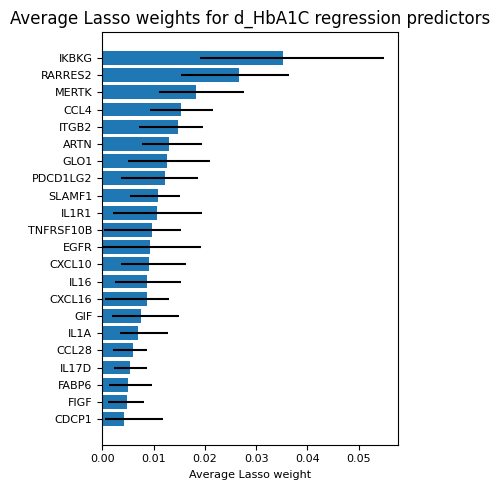

In [18]:
# TODO: plot the regression weights
gene_names = prot_names.loc[weights_means.index].gene_name

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names, weights_means, xerr=ranges)
plt.title('Average Lasso weights for d_HbA1C regression predictors')
ax.set_xlabel('Average Lasso weight', fontsize=8)
plt.tight_layout()

### b) dHbA1C classification LassoCV weights

In [19]:
weights_next_hba1c = prot_classification_weights.loc[prot_classification_weights.target=='d_class_hba1c', prot_classification_weights.columns!='target']

positive_weights = weights_next_hba1c.loc[:, (weights_next_hba1c > 0).all(0)]
negative_weights = weights_next_hba1c.loc[:, (weights_next_hba1c < 0).all(0)]

In [20]:
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [21]:
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [22]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values()

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

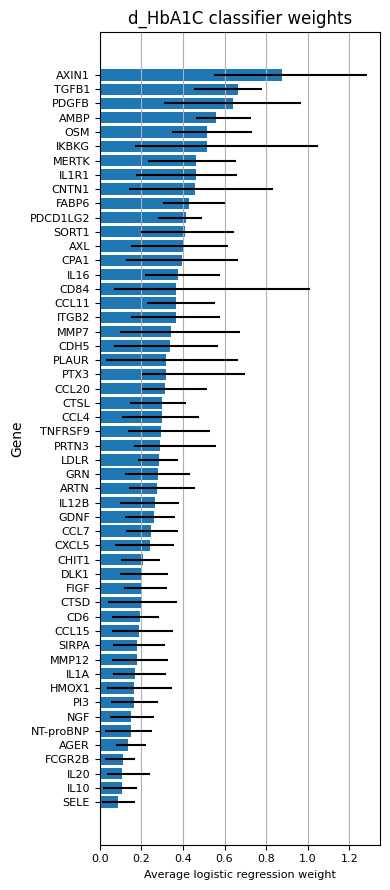

In [23]:
# TODO: plot the regression weights
gene_names = prot_names.loc[weights_means.index].gene_name

fig, ax = plt.subplots(figsize=(4, 9))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names, weights_means, xerr=ranges)
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Gene')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_all_positive_genes.png', dpi=300)

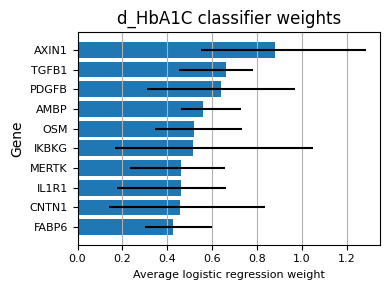

In [24]:
# Plot the top 10 classificaiton weights
gene_names = prot_names.loc[weights_means.index].gene_name

fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names[-10:], weights_means[-10:], xerr=ranges[:, -10:])
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.set_ylabel('Gene')
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_top_10_genes.png', dpi=300)

In [25]:
positive_class_d_hba1c_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
hba1c_class_uniprot_ids = prot_names.loc[positive_class_d_hba1c_prots].uniprot.tolist()

In [26]:
negative_class_d_hba1c_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
hba1c_class_negative_uniprot_ids = prot_names.loc[negative_class_d_hba1c_prots].uniprot.tolist()

In [27]:
print(len(hba1c_class_uniprot_ids), len(hba1c_class_negative_uniprot_ids))

52 39


#### Clinical variables - plot all positive, top 10 weights

In [28]:
weights_next_hba1c = clinical_classification_weights.loc[clinical_classification_weights.target=='d_class_hba1c', clinical_classification_weights.columns!='target']

positive_weights = weights_next_hba1c.loc[:, (weights_next_hba1c > 0).all(0)]
negative_weights = weights_next_hba1c.loc[:, (weights_next_hba1c < 0).all(0)]

In [29]:
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [30]:
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [31]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values()

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

In [32]:
weights_means

CRP HIGH SENSITIVITY    0.056157
is_m                    0.062104
TNF-ALPHA               0.081082
MERCURY, BLOOD          0.085338
GLOBULIN                0.104756
TOTAL NEUTROPHILS AB    0.137291
TRIGLYCERIDES           0.152825
GLUCOSE                 0.159797
age                     0.186082
EPA                     0.319392
CARBON DIOXIDE (CO2)    0.352031
ARACHIDONIC ACID        0.444744
DHA                     0.625045
CHLORIDE                0.661113
MCV                     1.127747
dtype: float64

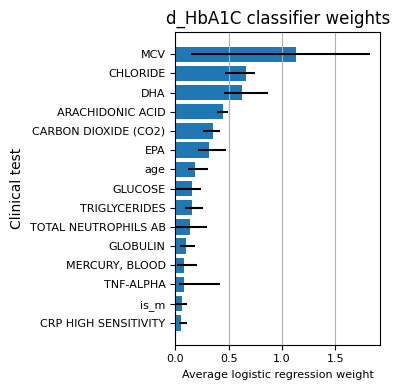

In [33]:
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 4))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(weights_means.index, weights_means, xerr=ranges)
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Clinical test')
plt.tight_layout()
plt.savefig('images_2023_10_18/clinical_coefficients_d_class_hba1c_all_positive.png', dpi=300)

In [34]:
weights_means = negative_weights.mean(0)
weights_means = weights_means.sort_values()

negative_weights = negative_weights.loc[:, weights_means.index]

weights_std = negative_weights.std(0)
weights_max = negative_weights.max(0) - weights_means
weights_min = weights_means - negative_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

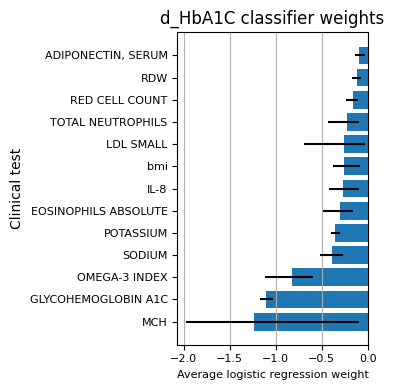

In [35]:
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 4))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(weights_means.index, weights_means, xerr=ranges)
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Clinical test')
plt.tight_layout()
plt.savefig('images_2023_10_18/clinical_coefficients_d_class_hba1c_all_negative.png', dpi=300)

#### Metabolites

In [36]:
weights_next_hba1c = met_classification_weights.loc[met_classification_weights.target=='d_class_hba1c', met_classification_weights.columns!='target']

positive_weights = weights_next_hba1c.loc[:, (weights_next_hba1c > 0).all(0)]
negative_weights = weights_next_hba1c.loc[:, (weights_next_hba1c < 0).all(0)]

In [92]:
np.savetxt('results_2023_10_18/selected_met_cols_names.txt', met_names.loc[weights_next_hba1c.columns[:-5]]['index'].to_numpy(), fmt='%s')

In [37]:
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [38]:
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [39]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values()

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

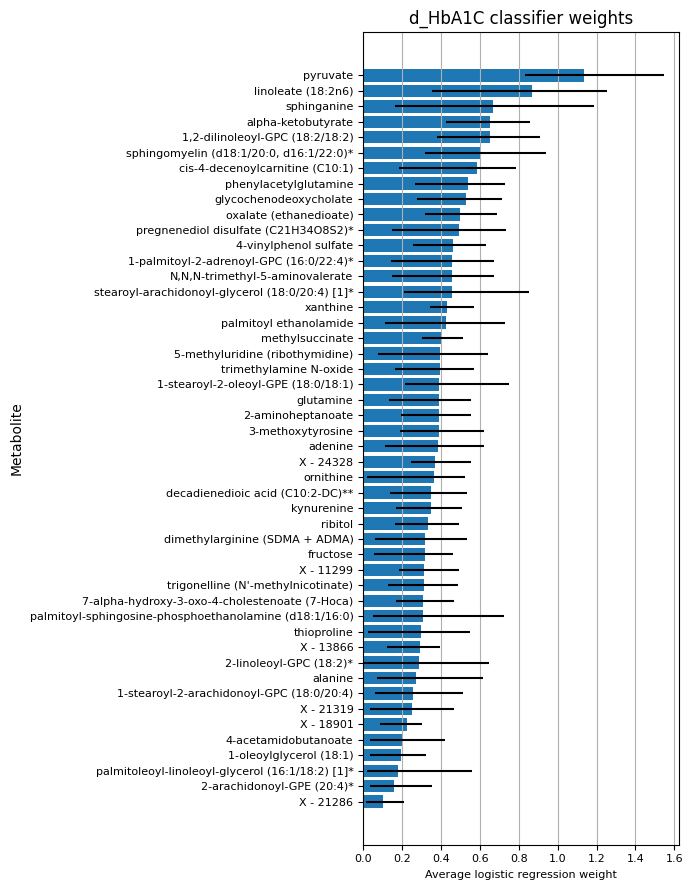

In [40]:
# TODO: plot the regression weights
gene_names = met_names.loc[weights_means.index]['index']

fig, ax = plt.subplots(figsize=(7, 9))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names, weights_means, xerr=ranges)
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Metabolite')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_all_positive_metabolites.png', dpi=300)

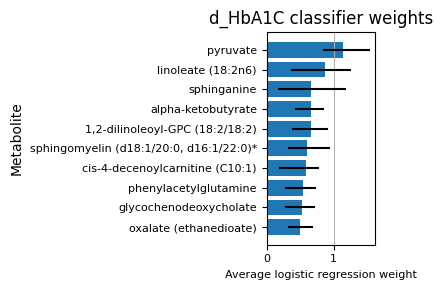

In [41]:
# Plot the top 10 classificaiton weights
gene_names = met_names.loc[weights_means.index]['index']

fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names[-10:], weights_means[-10:], xerr=ranges[:, -10:])
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.set_ylabel('Metabolite')
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_top_10_metabolites.png', dpi=300)

In [42]:
weights_means = negative_weights.mean(0)
weights_means = weights_means.sort_values()

negative_weights = negative_weights.loc[:, weights_means.index]

weights_std = negative_weights.std(0)
weights_max = negative_weights.max(0) - weights_means
weights_min = weights_means - negative_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

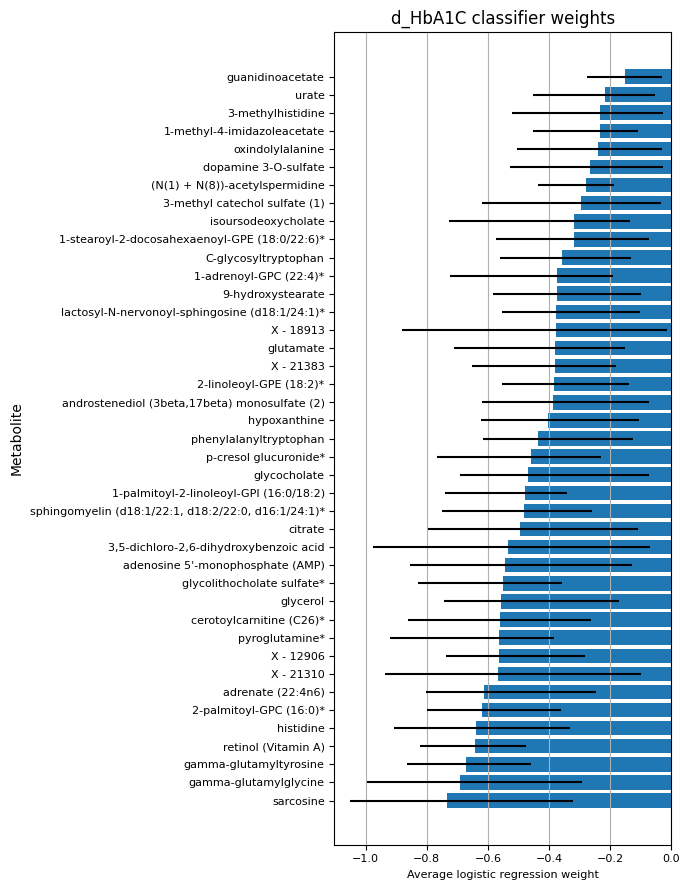

In [43]:
# TODO: plot the regression weights
gene_names = met_names.loc[weights_means.index]['index']

fig, ax = plt.subplots(figsize=(7, 9))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names, weights_means, xerr=ranges)
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Metabolite')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_all_negative_metabolites.png', dpi=300)

### c) current-HbA1C regression LassoCV weights

In [45]:
weights_current_hba1c = prot_regression_weights.loc[prot_regression_weights.target=='HbA1C', prot_regression_weights.columns!='target']
nonzero_weights = (weights_current_hba1c != 0).all(0)
weights_nonzeros = weights_current_hba1c.loc[:, nonzero_weights]

# TODO: separate positive and negative weights?
positive_weights = weights_current_hba1c.loc[:, (weights_current_hba1c > 0).all(0)]
negative_weights = weights_current_hba1c.loc[:, (weights_current_hba1c < 0).all(0)]

In [46]:
positive_regression_hba1c_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
current_hba1c_regression_uniprot_ids = prot_names.loc[positive_regression_hba1c_prots].uniprot.tolist()

In [47]:
negative_regression_hba1c_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
current_hba1c_regression_negative_uniprot_ids = prot_names.loc[negative_regression_hba1c_prots].uniprot.tolist()

In [48]:
print(len(current_hba1c_regression_uniprot_ids), len(current_hba1c_regression_negative_uniprot_ids))

36 39


### d) dGFR classification LassoCV weights

In [49]:
weights_next_gfr = prot_classification_weights.loc[prot_classification_weights.target=='d_class_gfr', prot_classification_weights.columns!='target']

positive_weights = weights_next_gfr.loc[:, (weights_next_gfr > 0).all(0)]
negative_weights = weights_next_gfr.loc[:, (weights_next_gfr < 0).all(0)]

In [50]:
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [51]:
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [52]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values()

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

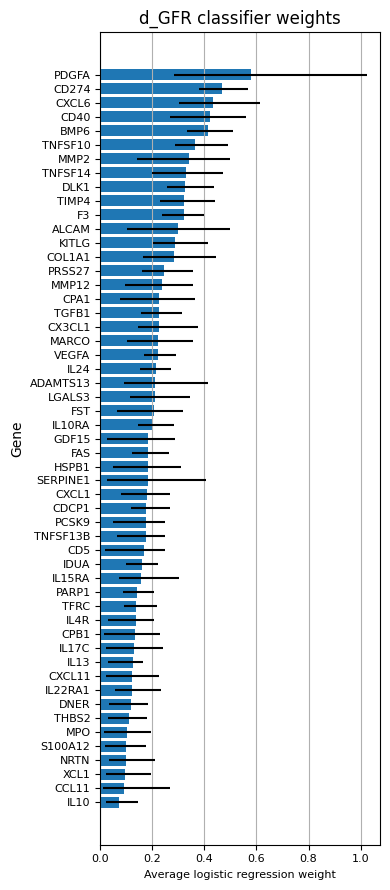

In [53]:
# TODO: plot the regression weights
gene_names = prot_names.loc[weights_means.index].gene_name

fig, ax = plt.subplots(figsize=(4, 9))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names, weights_means, xerr=ranges)
plt.title('d_GFR classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Gene')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_all_positive_genes.png')

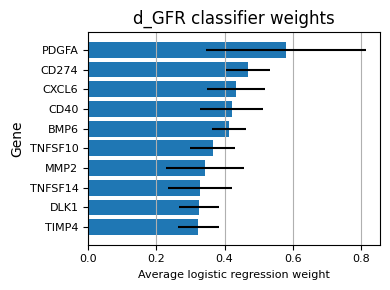

In [54]:
# Plot the top 10 classificaiton weights
gene_names = prot_names.loc[weights_means.index].gene_name

fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names[-10:], weights_means[-10:], xerr=weights_std[-10:])
plt.title('d_GFR classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.set_ylabel('Gene')
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_top_10_genes.png', dpi=300)

In [55]:
positive_class_d_gfr_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
gfr_class_uniprot_ids = prot_names.loc[positive_class_d_gfr_prots].uniprot.tolist()

In [56]:
negative_class_d_gfr_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
gfr_class_negative_uniprot_ids = prot_names.loc[negative_class_d_gfr_prots].uniprot.tolist()

In [57]:
print(len(gfr_class_uniprot_ids), len(gfr_class_negative_uniprot_ids))

53 50


#### Clinical variables - plot all positive, top 10 weights

In [58]:
weights_next_gfr = clinical_classification_weights.loc[clinical_classification_weights.target=='d_class_gfr', clinical_classification_weights.columns!='target']

positive_weights = weights_next_gfr.loc[:, (weights_next_gfr > 0).all(0)]
negative_weights = weights_next_gfr.loc[:, (weights_next_gfr < 0).all(0)]

In [59]:
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [60]:
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [61]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values()

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

In [62]:
weights_means

POTASSIUM                  0.070710
FERRITIN                   0.076138
METHYLMALONIC ACID         0.096134
GLYCOHEMOGLOBIN A1C        0.096134
PLATELET COUNT THOUSAND    0.099838
LDL SMALL                  0.109894
ADIPONECTIN, SERUM         0.123608
RDW                        0.140895
MONOCYTES ABSOLUTE         0.192211
MCHC                       0.223352
UREA NITROGEN              0.254266
GGT                        0.304320
IL-6                       0.333650
age                        0.537452
CREATININE ENZ, SER        0.829029
GFR, MDRD                  1.269079
dtype: float64

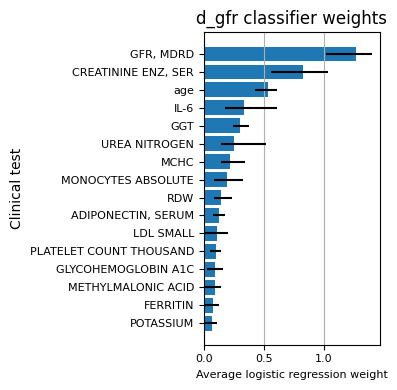

In [63]:
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 4))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(weights_means.index, weights_means, xerr=ranges)
plt.title('d_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Clinical test')
plt.tight_layout()
plt.savefig('images_2023_10_18/clinical_coefficients_d_class_gfr_all_positive.png', dpi=300)

In [64]:
weights_means = negative_weights.mean(0)
weights_means = weights_means.sort_values()

negative_weights = negative_weights.loc[:, weights_means.index]

weights_std = negative_weights.std(0)
weights_max = negative_weights.max(0) - weights_means
weights_min = weights_means - negative_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

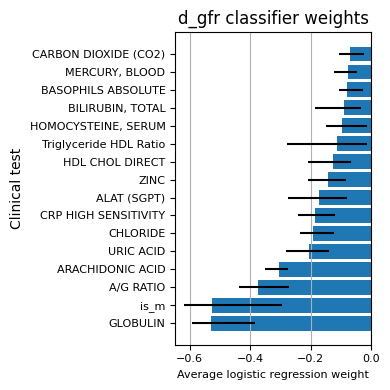

In [65]:
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 4))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(weights_means.index, weights_means, xerr=ranges)
plt.title('d_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Clinical test')
plt.tight_layout()
plt.savefig('images_2023_10_18/clinical_coefficients_d_class_gfr_all_negative.png', dpi=300)

#### Metabolites

In [77]:
weights_next_gfr = met_classification_weights.loc[met_classification_weights.target=='d_class_gfr', met_classification_weights.columns!='target']

positive_weights = weights_next_gfr.loc[:, (weights_next_gfr > 0).all(0)]
negative_weights = weights_next_gfr.loc[:, (weights_next_gfr < 0).all(0)]

In [78]:
positive_weights

,209,234,331,340,461,482,504,535,561,564,...,100021709,999933140,999946409,999946460,999946601,999952502,current,C,balanced_accuracy_score,f1_score
20,0.837129,0.282204,0.555374,0.236876,0.110661,1.079869,0.175735,0.363220,0.489830,0.336083,...,0.920989,0.405294,0.625790,0.060984,0.225692,0.737005,1.503522,1.0,0.592405,0.424242
21,0.678054,0.640191,0.621905,0.190597,0.203607,1.156599,0.166213,0.546894,0.027179,0.227383,...,1.136805,0.441700,0.390922,0.395257,0.244975,0.457533,1.336400,1.0,0.581611,0.372881
22,0.567447,0.180158,0.487271,0.493610,0.234582,1.009039,0.258764,0.136508,0.525679,0.071321,...,0.758337,0.677973,0.520191,0.085496,0.474793,0.746098,1.419051,1.0,0.558451,0.344828
23,0.186450,0.297313,0.628314,0.461034,0.543662,1.266560,0.553375,0.723507,0.479938,0.488656,...,1.242625,0.344201,0.216480,0.225160,0.356714,0.347012,1.576669,1.0,0.510739,0.250000
24,0.316655,0.559142,0.351270,0.537675,0.321193,1.469247,0.602073,0.261375,0.474610,0.369277,...,1.184673,0.522503,0.296226,0.289058,0.273118,0.658188,1.443365,1.0,0.628245,0.459016
25,0.245801,0.552732,0.223483,0.374520,0.267737,1.175425,0.338242,0.499191,1.022279,0.352767,...,1.082419,0.678193,0.449907,0.046753,0.232462,0.221239,1.342628,1.0,0.519538,0.295082
26,0.341173,0.578701,0.240771,0.616760,0.258056,1.201678,0.245623,0.430780,0.754675,0.007932,...,0.488360,0.600965,0.676787,0.271218,0.334592,0.737934,1.393023,1.0,0.649731,0.418605
27,0.192469,0.672408,0.248613,0.640395,0.271840,1.135002,0.318306,0.304360,0.420127,0.466945,...,1.156582,0.672097,0.341102,0.311919,0.165764,0.497917,1.689245,1.0,0.597436,0.430769
28,0.286307,0.651471,0.198707,0.253408,0.233172,1.015505,0.396746,0.294264,0.893868,0.046109,...,0.280071,0.573199,0.449760,0.067823,0.528677,0.563337,1.151104,1.0,0.550676,0.376812
29,0.495405,0.197544,0.181610,0.494842,0.493162,1.408137,0.291066,0.329500,0.568451,0.092332,...,0.837976,0.543771,0.122790,0.464443,0.277336,0.557618,1.719651,1.0,0.556827,0.354839


In [79]:
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [80]:
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [81]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values()

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

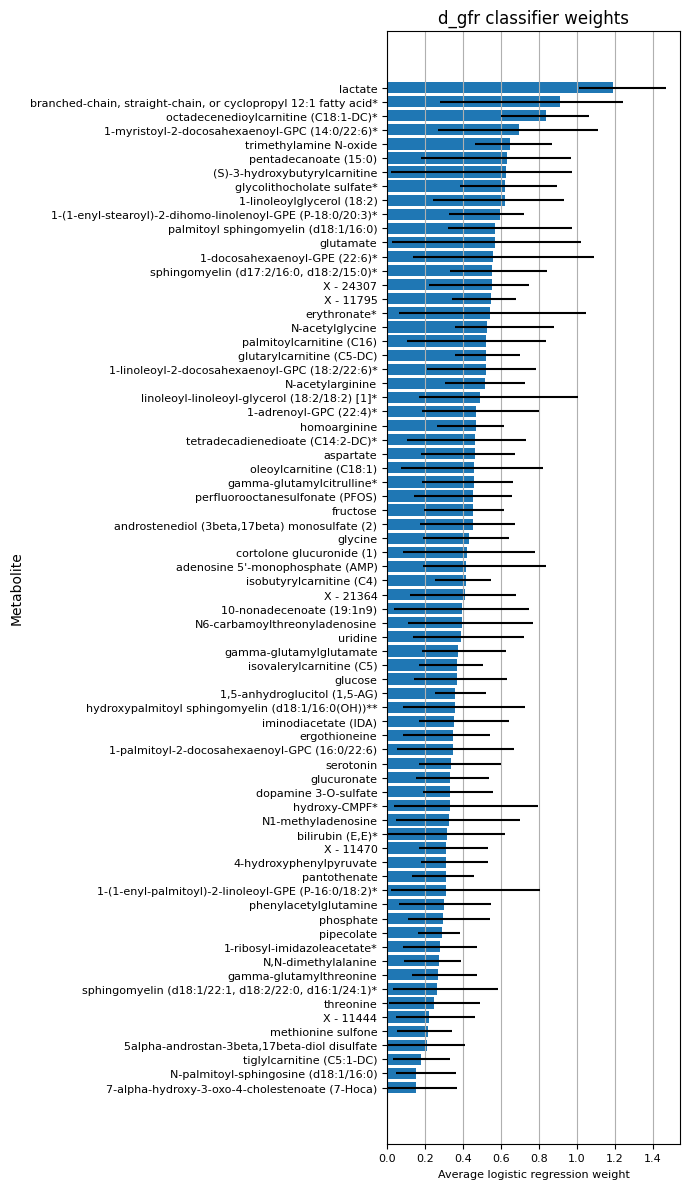

In [82]:
# TODO: plot the regression weights
gene_names = met_names.loc[weights_means.index]['index']

fig, ax = plt.subplots(figsize=(7, 12))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names, weights_means, xerr=ranges)
plt.title('d_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Metabolite')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_all_positive_metabolites.png', dpi=300)

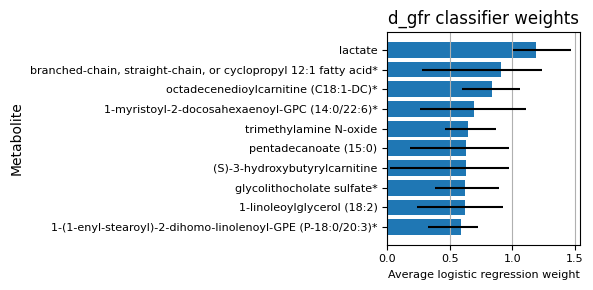

In [83]:
# Plot the top 10 classificaiton weights
gene_names = met_names.loc[weights_means.index]['index']

fig, ax = plt.subplots(figsize=(6, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names[-10:], weights_means[-10:], xerr=ranges[:, -10:])
plt.title('d_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.set_ylabel('Metabolite')
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_top_10_metabolites.png', dpi=300)

In [84]:
weights_means = negative_weights.mean(0)
weights_std = negative_weights.std(0)
weights_means = weights_means.sort_values()
weights_std = weights_std[weights_means.index]

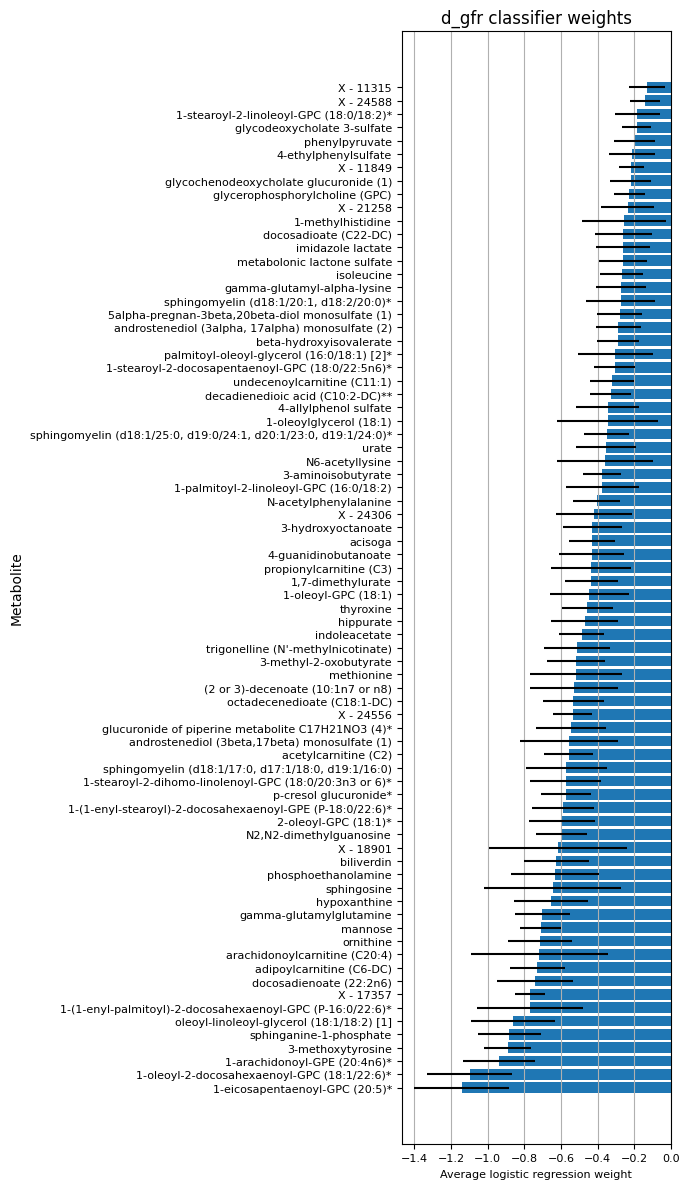

In [85]:
# TODO: plot the regression weights
gene_names = met_names.loc[weights_means.index]['index']

fig, ax = plt.subplots(figsize=(7, 12))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(gene_names, weights_means, xerr=weights_std)
plt.title('d_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Metabolite')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_all_negative_metabolites.png', dpi=300)